# Handwritten Digit Image Classifier

This notebook trains a Convolutional Neural Network (CNN) on the MNIST dataset to recognize handwritten digits (0–9).  
It then demonstrates inference on custom images, handling dark or light backgrounds automatically.

**Key steps:**
1. Load and explore MNIST data  
2. Preprocess (reshape, normalize)  
3. Build CNN architecture (`Conv2D` → `MaxPooling` → `Flatten` → `Dense`)  
4. Compile, train, and evaluate model  
5. Load external image(s), preprocess, and predict  


## 1. Data Loading & Exploration

We begin by loading the MNIST dataset from Keras.  
- `x_train`, `x_test` are images (28×28 pixels).  
- `y_train`, `y_test` are integer labels 0–9.  

Below we inspect shapes and visualize one sample.


In [1]:
#Here we load the Mnist data from Keras
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#get an idea of shape of train data
x_train.shape

(60000, 28, 28)

In [2]:
x_test.shape

(10000, 28, 28)

6


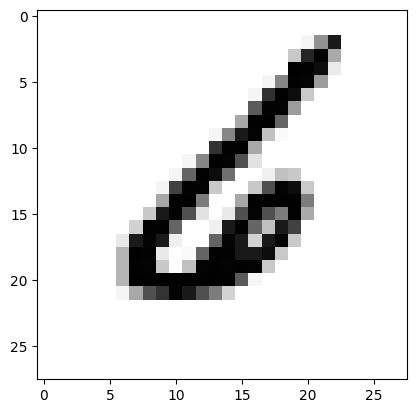

In [3]:
#Here we preview an element of the data
import matplotlib.pyplot as plt
 # Only use this if using iPython
image_index = 32143 # You may select anything up to 60,000
print(y_train[image_index]) # To display the label number
plt.imshow(x_train[image_index], cmap='Greys') #to show the image associated with label

In [4]:
x_train[image_index]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,  21, 132, 233,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  82, 223, 253, 111,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 254, 253, 244,  40,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  21, 142, 253, 252, 122,   0,   0,   0,   0,
          0,   0],
       [  

## 2. Preprocessing

Before training a neural network, we need to prepare the image data in a format suitable for deep learning. This includes reshaping, type conversion, and normalization.

---

###  Reshaping the Input

The MNIST dataset originally has shapes:

- `x_train.shape → (60000, 28, 28)`  
- `x_test.shape → (10000, 28, 28)`

This means:
- 60,000 training images and 10,000 test images  
- Each image is 28×28 pixels  
- But there is **no channel dimension** (i.e., color information)

#### ➤ Why reshape to `(28, 28, 1)`?

CNNs expect input in the format:  
**`(samples, height, width, channels)`**

- The `1` at the end indicates these are **grayscale images** (1 channel), unlike RGB images which have 3 channels.
- Reshaping ensures compatibility with layers like `Conv2D`, which require 4D input.
- Without this step, the model would raise a shape mismatch error

In [5]:
#Reshaping and preprocessing
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


In [6]:
x_train[image_index]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

## 3. Model Architecture

We define a **Convolutional Neural Network (CNN)** using the Keras `Sequential` API. CNNs are particularly effective for image classification tasks like MNIST because they can learn spatial hierarchies of features.

Here’s a breakdown of the architecture and why each layer is used in this order:

---

### 🔹 `Input(shape=(28, 28, 1))`  
This defines the shape of the input image: 28×28 pixels, with 1 color channel (grayscale). Declaring an `Input` layer first is the modern practice in Keras, making the model easier to read and avoiding warnings.

---

### 🔹 `Conv2D(28, kernel_size=(3, 3), activation='relu')`  
This is the first convolutional layer. It applies 28 different 3×3 filters (kernels) to the input image to extract features like edges, curves, or small patterns.

- **Why convolution first?**  
  Convolutions scan the image with local filters to learn spatial features.
- **Why ReLU?**  
  The `ReLU` activation introduces non-linearity, helping the model learn complex patterns.
- **Why 28 filters?**  
  A small number of filters keeps the model lightweight while still expressive.

---

### 🔹 `MaxPooling2D(pool_size=(2, 2))`  
After extracting features, we reduce the spatial dimensions using pooling. Max pooling picks the maximum value in each 2×2 window.

- **Why pooling?**  
  It reduces the number of parameters and computation, and also helps the model become more translation-invariant (robust to slight shifts in the digit’s position).

---

### 🔹 `Flatten()`  
This layer converts the 2D output of the conv-pooling layers into a 1D vector, so we can pass it to fully connected (`Dense`) layers for classification.

- **Why flatten now?**  
  Because Dense layers expect a vector input — this is the “bridge” between convolution and classification.

---

### 🔹 `Dense(64, activation='relu')`  
This is a fully connected layer with 64 neurons. It learns abstract representations from the flattened features.

- **Why Dense here?**  
  Now that we’ve extracted features, we need to learn patterns across the whole digit to classify it correctly.
- **Why 64 units?**  
  It’s a reasonable size that balances model capacity and training speed.

---

### 🔹 `Dropout(0.2)`  
Dropout randomly turns off 20% of the neurons during training to prevent overfitting.

- **Why dropout now?**  
  Fully connected layers are more prone to overfitting than convolutional layers, so regularization is added right after.

---

### 🔹 `Dense(10, activation='softmax')`  
The final classification layer. It outputs 10 probabilities corresponding to digits 0–9.

- **Why 10 neurons?**  
  Because we have 10 possible classes.
- **Why softmax?**  
  Softmax converts raw scores into probabilities that sum to 1, making it suitable for multi-class classification.

---

### 🧠 Summary  
This architecture starts with convolutional layers to learn **spatial features**, and ends with dense layers to make a **prediction based on those features**. It's a common and effective CNN pattern for small image datasets like MNIST.


In [7]:
#Building to Keras
# Importing the required Keras modules containing model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
# Creating a Sequential Model and adding the layers
model = Sequential() #chosen Keras model
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape)) #convolution
model.add(MaxPooling2D(pool_size=(2, 2))) #pooling layer
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(64, activation=tf.nn.relu)) #dense layer relu
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax)) #dense layer softmax

C:\Users\pdhye\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 4. Compile & Train

- **Optimizer:** Adam  
- **Loss:** Sparse Categorical Crossentropy  
- **Metrics:** Accuracy  

We train for 20 epochs and will record total training time.


In [9]:
#Compiling and fitting the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9523 - loss: 0.1625
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9714 - loss: 0.0928
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9777 - loss: 0.0686 
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9839 - loss: 0.0522
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9851 - loss: 0.0444
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9866 - loss: 0.0401
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9887 - loss: 0.0318
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9899 - loss: 0.0294
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9913 - loss: 0.0264
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9920 - loss: 0.0243


In [10]:
#evaluating
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9773 - loss: 0.0799


[0.06009311601519585, 0.9836000204086304]

## 5. Evaluation Results & Conclusions

After training our CNN for 20 epochs, we evaluated its performance on the held-out test set:

- **Test Loss:** 0.06 
- **Test Accuracy:** 0.98

**What this means:**  
- A low test loss indicates the model’s predictions closely match the true labels.  
- Achieving 98% accuracy shows the network correctly classifies nearly all handwritten digits.

**Key Takeaways:**  
- Our simple two-layer convolutional architecture effectively captures digit features.  
- Dropout helped prevent overfitting, ensuring strong generalization to unseen data.  
- At ~5 seconds per epoch, training is fast and scalable for similar image tasks.

With these results, we have a robust baseline CNN for MNIST. Future improvements could include adding more convolutional blocks, using batch normalization, or incorporating data augmentation to push accuracy even higher.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
4


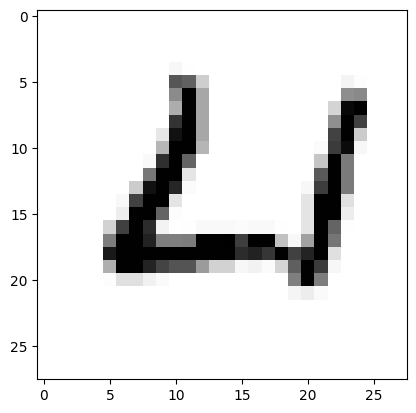

In [11]:
#testing on test data
image_index = 33 #choose random value up to 10000
plt.imshow(x_test[image_index].reshape(28, 28),cmap='Greys')
pred = model.predict(x_test[image_index].reshape(1, 28, 28, 1))
print(pred.argmax())


# Prediction on sample image

In [12]:
import cv2
import numpy as np
def load_and_prepare_image(path, auto_invert=True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (28, 28))

    if auto_invert:
        mean_val = np.mean(img)
        # If background is dark (low mean), it's likely black digit on white → invert
        if mean_val < 127:
            img = 255 - img  # Invert only if image is dark

    img = img.astype('float32')
    img = img / 255.0
    img = img.reshape(1, 28, 28, 1)
    return img;

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


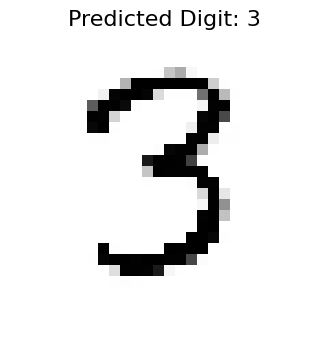

In [17]:
# Set invert=True or False depending on your input image
img_array = load_and_prepare_image("num3.jpg",)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)


plt.figure(figsize=(4, 4))
plt.imshow(img_array.reshape(28, 28), cmap='gray')
plt.title(f"Predicted Digit: {predicted_class}", fontsize=16)
plt.axis('off')
plt.show()
